In [1]:
%load_ext watermark
%watermark


Last updated: 2023-02-24T09:00:43.652565-05:00

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.10.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [2]:
import pandas as pd

import numpy as np

import seaborn as sns

from ipywidgets import interact, FloatSlider, IntSlider, fixed

from IPython.display import display

from scipy import stats

import pickle

import dill

from datetime import datetime

import matplotlib.pyplot as plt

import os

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.model_selection import learning_curve, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, BayesianRidge
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin

import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.python.platform import build_info as build
from tensorflow.keras import backend
from tensorflow.keras.optimizers import RMSprop

from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Dropout
from keras.callbacks import TensorBoard
from keras.constraints import maxnorm

sns.set(font_scale=0.7)


# Resume

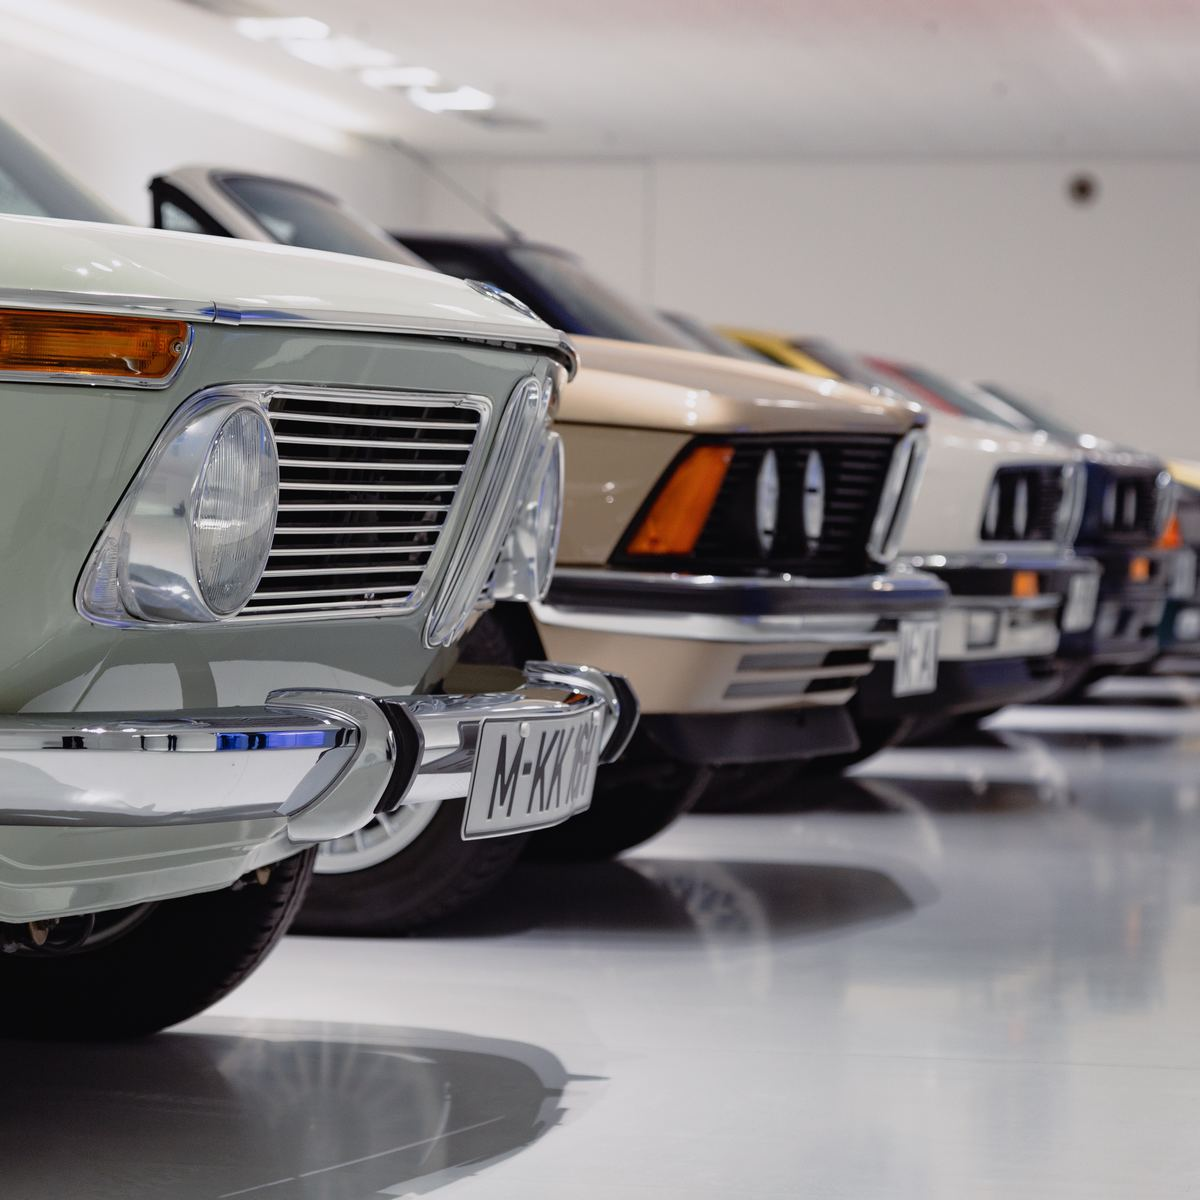

# Data Collection

In [3]:
df = pd.read_csv('resources/vehicles_us.csv', parse_dates=['date_posted'])
df.head()


,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011.0,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19
1,25500,NaN,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
2,5500,2013.0,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,NaN,2019-02-07,79
3,1500,2003.0,ford f-150,fair,8.0,gas,NaN,automatic,pickup,NaN,NaN,2019-03-22,9
4,14900,2017.0,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,NaN,2019-04-02,28


Se eliminan los registros completamente `vacíos` y los `duplicados`.

In [4]:
n = df.shape[0]

df.dropna(axis=0, how='all', inplace=True)
df.drop_duplicates(keep='first', inplace=True)

print(f'Eliminados: {n - df.shape[0]}')
df.shape


Eliminados: 0


(51525, 13)

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   price         51525 non-null  int64         
 1   model_year    47906 non-null  float64       
 2   model         51525 non-null  object        
 3   condition     51525 non-null  object        
 4   cylinders     46265 non-null  float64       
 5   fuel          51525 non-null  object        
 6   odometer      43633 non-null  float64       
 7   transmission  51525 non-null  object        
 8   type          51525 non-null  object        
 9   paint_color   42258 non-null  object        
 10  is_4wd        25572 non-null  float64       
 11  date_posted   51525 non-null  datetime64[ns]
 12  days_listed   51525 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(6)
memory usage: 5.5+ MB


In [6]:
target_column = 'price'


In [7]:
df_bk = df.copy()


# Data Transform

In [8]:
cardinality_resume = pd.DataFrame(columns=['DATA_TYPE',
                                           'MORE_COMMON_VAL', 'MORE_COMMON_QTY', 'MORE_COMMON_PERC',
                                           'LESS_COMMON_VAL', 'LESS_COMMON_QTY', 'LESS_COMMON_PERC'])

for column in df.columns:
    n_per_value = df[column].value_counts(dropna=False)
    more_common_qty = n_per_value.iloc[0]
    less_common_qty = n_per_value.iloc[-1]

    cardinality_resume.loc[column] = {'DATA_TYPE': df[column].dtype,
                                      'MORE_COMMON_VAL': n_per_value.index[0],
                                      'MORE_COMMON_QTY': more_common_qty,
                                      'MORE_COMMON_PERC': round(more_common_qty * 100 / (1.0 * len(df)), 3),
                                      'LESS_COMMON_VAL': n_per_value.index[-1],
                                      'LESS_COMMON_QTY': less_common_qty,
                                      'LESS_COMMON_PERC': round(less_common_qty * 100 / (1.0 * len(df)), 3)}

cardinality_resume


,DATA_TYPE,MORE_COMMON_VAL,MORE_COMMON_QTY,MORE_COMMON_PERC,LESS_COMMON_VAL,LESS_COMMON_QTY,LESS_COMMON_PERC
price,int64,1.0,798,1.549,7455.0,1,0.002
model_year,float64,NaN,3619,7.024,1929.0,1,0.002
model,object,ford f-150,2796,5.426,mercedes-benz benze sprinter 2500,41,0.080
condition,object,excellent,24773,48.080,salvage,115,0.223
cylinders,float64,8.0,15844,30.750,12.0,2,0.004
fuel,object,gas,47288,91.777,electric,6,0.012
odometer,float64,NaN,7892,15.317,139573.0,1,0.002
transmission,object,automatic,46902,91.028,other,1794,3.482
type,object,SUV,12405,24.076,bus,24,0.047
paint_color,object,white,10029,19.464,purple,102,0.198


In [9]:
cardinality_resume = cardinality_resume.loc[(cardinality_resume.MORE_COMMON_PERC > 90.) |
                                            ((cardinality_resume.MORE_COMMON_PERC > 25.) & (cardinality_resume.MORE_COMMON_VAL.isna()))]
cardinality_resume


,DATA_TYPE,MORE_COMMON_VAL,MORE_COMMON_QTY,MORE_COMMON_PERC,LESS_COMMON_VAL,LESS_COMMON_QTY,LESS_COMMON_PERC
fuel,object,gas,47288,91.777,electric,6,0.012
transmission,object,automatic,46902,91.028,other,1794,3.482
is_4wd,float64,NaN,25953,50.370,1.0,25572,49.630


In [10]:
for col in cardinality_resume.index:
    display(df[col].value_counts(normalize=True, dropna=False))
    print('----------------------------------')


gas         0.917768
diesel      0.072082
hybrid      0.007938
other       0.002096
electric    0.000116
Name: fuel, dtype: float64

----------------------------------


automatic    0.910277
manual       0.054905
other        0.034818
Name: transmission, dtype: float64

----------------------------------


NaN    0.503697
1.0    0.496303
Name: is_4wd, dtype: float64

----------------------------------


- Se eliminarán las columnas `fuel` y `transmission` al tener más del `90%` un valor repetido.
- No se eliminará la columna `is_4wd` porque los `NaN` serán sustituidos más adelante.

In [11]:
class VehiclesDataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vif=False, target_column=None):
        if vif == True and target_column is None:
            raise Exception("Target can't be empty with VIF.")

        self.vif = vif
        self.target_column = target_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        X.drop(labels=['fuel', 'transmission'], axis=1, inplace=True)

        X['model'] = X.model.apply(lambda x: x.split()[0])

        if self.vif == True:
            X = self.__vif_excec(X)

        return X

    def __vif_excec(self, X):
        features = list(X.select_dtypes(include=np.number).columns)
        features.remove(self.target_column)
        exclude_features = list(set(X.columns) - set(features))

        include_df, exclude_df = X[features], X[exclude_features]

        target_values = X[self.target_column]

        while True:
            vif_data = self.__vif_calc(include_df)

            big_vif = vif_data[vif_data.VIF >= 5].sort_values(by='VIF',
                                                              ascending=False).head(1)

            if big_vif.shape[0] > 0:
                feature_vif = big_vif.iloc[0]['FEAUTURE']
                vif_value = str(big_vif.iloc[0]['VIF'])

                features.remove(feature_vif)
                include_df = include_df[features]

                print(f'Removed {feature_vif} with VIF={vif_value}.')
            else:
                break

        X = include_df.merge(right=exclude_df, how='inner',
                             left_index=True, right_index=True, validate='1:1')
        X[self.target_column] = target_values

        return X

    def __vif_calc(self, X):
        vif_data = pd.DataFrame()
        vif_data['FEAUTURE'] = X.columns

        vif_data['VIF'] = [variance_inflation_factor(exog=X.values, exog_idx=i)
                           for i, _ in enumerate(X.columns)]

        return vif_data


dill.dump(VehiclesDataTransformer,
          open('resources/data_transformer', 'wb'))

data_transf = VehiclesDataTransformer(vif=False, target_column=target_column)
df = data_transf.fit_transform(df)
df.head()


,price,model_year,model,condition,cylinders,odometer,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011.0,bmw,good,6.0,145000.0,SUV,NaN,1.0,2018-06-23,19
1,25500,NaN,ford,good,6.0,88705.0,pickup,white,1.0,2018-10-19,50
2,5500,2013.0,hyundai,like new,4.0,110000.0,sedan,red,NaN,2019-02-07,79
3,1500,2003.0,ford,fair,8.0,NaN,pickup,NaN,NaN,2019-03-22,9
4,14900,2017.0,chrysler,excellent,4.0,80903.0,sedan,black,NaN,2019-04-02,28


# Outliers

In [12]:
def build_outliers_resume():
    resume = pd.DataFrame(columns=['OUTLIER', 'FREQUENCY', 'UNIQUE_OUTLIERS', 'UNIQUE_VALUES', 'DATA_TYPE'])
    resume.OUTLIER = resume.OUTLIER.astype(bool)

    for col in df.columns:
        try:
            df[col] = df[col].astype(float)
        except:
            continue

        # zcores absoluto de cada valor de la columna seleccionada
        zcores = np.abs(stats.zscore(df[col]))

        outliers = df[zcores > 3][col].values
        n_outliers = len(outliers)

        resume.loc[col] = {'OUTLIER': False if n_outliers == 0 else True,
                           'FREQUENCY': n_outliers,
                           'UNIQUE_OUTLIERS': set(outliers),
                           'UNIQUE_VALUES': df[col].unique(),
                           'DATA_TYPE': df[col].dtype}

    return resume


build_outliers_resume()


,OUTLIER,FREQUENCY,UNIQUE_OUTLIERS,UNIQUE_VALUES,DATA_TYPE
price,True,619,"{64000.0, 47617.0, 42500.0, 46601.0, 64010.0, ...","[9400.0, 25500.0, 5500.0, 1500.0, 14900.0, 149...",float64
model_year,False,0,{},"[2011.0, nan, 2013.0, 2003.0, 2017.0, 2014.0, ...",float64
cylinders,False,0,{},"[6.0, 4.0, 8.0, nan, 5.0, 10.0, 3.0, 12.0]",float64
odometer,False,0,{},"[145000.0, 88705.0, 110000.0, nan, 80903.0, 57...",float64
is_4wd,False,0,{},"[1.0, nan]",float64
days_listed,True,703,"{125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131...","[19.0, 50.0, 79.0, 9.0, 28.0, 15.0, 73.0, 68.0...",float64


In [13]:
zcores = np.abs(stats.zscore(df[target_column]))
idx = zcores[zcores > 3].index
df.drop(axis=0, index=idx, inplace=True)
df_bk.drop(axis=0, index=idx, inplace=True)


- Se sustituyen los outliers por NaN. 
- Las columnas `discretas` se convierte automáticamente a `continuas` ya que NaN es un valor continuo.
- Analizar detalladamente cada columna, a no todas se le aplican los cambios. 
- No se actualiza la columna objetivo.

In [14]:
class VehiclesOutlierTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ops = ['model_year', 'cylinders', 'odometer', 'days_listed']

    def fit(self, X, y=None):
        self.sts = {col: {'mean': X[col].mean(), 'std': X[col].std()}
                    for col in self.ops}

        return self

    def transform(self, X):
        X = X.copy()

        for col in self.ops:
            zcores = \
                np.abs((X[col] - self.sts[col]['mean']) / self.sts[col]['std'])
            idx = zcores[zcores > 3].index

            X.loc[idx, col] = np.nan

        X.loc[~X['is_4wd'].isin([0, 1]), 'is_4wd'] = None

        return X


dill.dump(VehiclesOutlierTransformer,
          open('resources/outlier_transformer', 'wb'))

outlier_transf = VehiclesOutlierTransformer()
df = outlier_transf.fit_transform(df)
df.head()


,price,model_year,model,condition,cylinders,odometer,type,paint_color,is_4wd,date_posted,days_listed
0,9400.0,2011.0,bmw,good,6.0,145000.0,SUV,NaN,1.0,2018-06-23,19.0
1,25500.0,NaN,ford,good,6.0,88705.0,pickup,white,1.0,2018-10-19,50.0
2,5500.0,2013.0,hyundai,like new,4.0,110000.0,sedan,red,NaN,2019-02-07,79.0
3,1500.0,2003.0,ford,fair,8.0,NaN,pickup,NaN,NaN,2019-03-22,9.0
4,14900.0,2017.0,chrysler,excellent,4.0,80903.0,sedan,black,NaN,2019-04-02,28.0


In [15]:
build_outliers_resume()


,OUTLIER,FREQUENCY,UNIQUE_OUTLIERS,UNIQUE_VALUES,DATA_TYPE
price,True,500,"{37888.0, 41986.0, 41990.0, 37894.0, 41995.0, ...","[9400.0, 25500.0, 5500.0, 1500.0, 14900.0, 149...",float64
model_year,False,0,{},"[2011.0, nan, 2013.0, 2003.0, 2017.0, 2014.0, ...",float64
cylinders,False,0,{},"[6.0, 4.0, 8.0, nan, 5.0, 10.0, 3.0]",float64
odometer,False,0,{},"[145000.0, 88705.0, 110000.0, nan, 80903.0, 57...",float64
is_4wd,False,0,{},"[1.0, nan]",float64
days_listed,False,0,{},"[19.0, 50.0, 79.0, 9.0, 28.0, 15.0, 73.0, 68.0...",float64


# Imputers

In [16]:
def build_imputers_resume():
    resume = pd.DataFrame()

    for column in df.columns:
        resume.loc[column, 'TYPE'] = df[column].dtype
        resume.loc[column, 'VALUES'] = str(df[column].unique())
        resume.loc[column, 'VALUES_LEN'] = len(df[column].unique())
        resume.loc[column, 'NULL_COUNT'] = df[column].isnull().sum(axis=0)

    return resume


build_imputers_resume()


,TYPE,VALUES,VALUES_LEN,NULL_COUNT
price,float64,[ 9400. 25500. 5500. ... 3636. 9249. 7455.],3217.0,0.0
model_year,float64,[2011. nan 2013. 2003. 2017. 2014. 2015. 201...,29.0,4107.0
model,object,['bmw' 'ford' 'hyundai' 'chrysler' 'toyota' 'h...,19.0,0.0
condition,object,['good' 'like new' 'fair' 'excellent' 'salvage...,6.0,0.0
cylinders,float64,[ 6. 4. 8. nan 5. 10. 3.],7.0,5204.0
odometer,float64,[145000. 88705. 110000. ... 121778. 181500. 1...,17398.0,8045.0
type,object,['SUV' 'pickup' 'sedan' 'truck' 'coupe' 'van' ...,13.0,0.0
paint_color,object,[nan 'white' 'red' 'black' 'blue' 'grey' 'silv...,13.0,9169.0
is_4wd,float64,[ 1. nan],2.0,25864.0
date_posted,datetime64[ns],['2018-06-23T00:00:00.000000000' '2018-10-19T0...,354.0,0.0


Se eliminan los registros de las columnas que no tienen sentidos `imputarlas` (`variable objetivo`, etc).

In [17]:
idx = df[df[target_column].isna()].index
df.drop(axis=0, index=idx, inplace=True)
df_bk.drop(axis=0, index=idx, inplace=True)


In [18]:
class VehiclesImputeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.ops = {'model_year': X['model_year'].median(),
                    'model': X['model'].mode()[0],
                    'condition': X['condition'].mode()[0],
                    'cylinders': X['cylinders'].median(),
                    'odometer': X['odometer'].median(),
                    'type': X['type'].mode()[0],
                    'paint_color': X['paint_color'].mode()[0],
                    'is_4wd': 0,
                    'days_listed': X['days_listed'].median()}

        return self

    def transform(self, X):
        X = X.copy()

        for k in self.ops:
            X[k].fillna(value=self.ops[k], inplace=True)

        return X


dill.dump(VehiclesImputeTransformer,
          open('resources/impute_transformer', 'wb'))

impute_transf = VehiclesImputeTransformer()
df = impute_transf.fit_transform(df)
df.head()


,price,model_year,model,condition,cylinders,odometer,type,paint_color,is_4wd,date_posted,days_listed
0,9400.0,2011.0,bmw,good,6.0,145000.0,SUV,white,1.0,2018-06-23,19.0
1,25500.0,2011.0,ford,good,6.0,88705.0,pickup,white,1.0,2018-10-19,50.0
2,5500.0,2013.0,hyundai,like new,4.0,110000.0,sedan,red,0.0,2019-02-07,79.0
3,1500.0,2003.0,ford,fair,8.0,113419.0,pickup,white,0.0,2019-03-22,9.0
4,14900.0,2017.0,chrysler,excellent,4.0,80903.0,sedan,black,0.0,2019-04-02,28.0


In [19]:
build_imputers_resume()


,TYPE,VALUES,VALUES_LEN,NULL_COUNT
price,float64,[ 9400. 25500. 5500. ... 3636. 9249. 7455.],3217.0,0.0
model_year,float64,[2011. 2013. 2003. 2017. 2014. 2015. 2012. 200...,28.0,0.0
model,object,['bmw' 'ford' 'hyundai' 'chrysler' 'toyota' 'h...,19.0,0.0
condition,object,['good' 'like new' 'fair' 'excellent' 'salvage...,6.0,0.0
cylinders,float64,[ 6. 4. 8. 5. 10. 3.],6.0,0.0
odometer,float64,[145000. 88705. 110000. ... 121778. 181500. 1...,17397.0,0.0
type,object,['SUV' 'pickup' 'sedan' 'truck' 'coupe' 'van' ...,13.0,0.0
paint_color,object,['white' 'red' 'black' 'blue' 'grey' 'silver' ...,12.0,0.0
is_4wd,float64,[1. 0.],2.0,0.0
date_posted,datetime64[ns],['2018-06-23T00:00:00.000000000' '2018-10-19T0...,354.0,0.0


# Exploratory Data Analysis (EDA)

### Data Types

In [20]:
type_resume = pd.DataFrame()

for column in df.columns:
    type_resume.loc[column, 'TYPE'] = df[column].dtype
    type_resume.loc[column, 'VALUES'] = str(df[column].unique())
    type_resume.loc[column, 'VALUES_LEN'] = len(df[column].unique())

type_resume


,TYPE,VALUES,VALUES_LEN
price,float64,[ 9400. 25500. 5500. ... 3636. 9249. 7455.],3217.0
model_year,float64,[2011. 2013. 2003. 2017. 2014. 2015. 2012. 200...,28.0
model,object,['bmw' 'ford' 'hyundai' 'chrysler' 'toyota' 'h...,19.0
condition,object,['good' 'like new' 'fair' 'excellent' 'salvage...,6.0
cylinders,float64,[ 6. 4. 8. 5. 10. 3.],6.0
odometer,float64,[145000. 88705. 110000. ... 121778. 181500. 1...,17397.0
type,object,['SUV' 'pickup' 'sedan' 'truck' 'coupe' 'van' ...,13.0
paint_color,object,['white' 'red' 'black' 'blue' 'grey' 'silver' ...,12.0
is_4wd,float64,[1. 0.],2.0
date_posted,datetime64[ns],['2018-06-23T00:00:00.000000000' '2018-10-19T0...,354.0


In [21]:
df.model_year = df.model_year.astype(int)
df.cylinders = df.cylinders.astype(int)
df.is_4wd = df.is_4wd.astype(bool)
df.days_listed = df.days_listed.astype(int)
df.paint_color = df.paint_color.astype('category')
df.condition = df.condition.astype('category')
df.model = df.model.astype('category')
df.type = df.type.astype('category')

df.dtypes


price                 float64
model_year              int32
model                category
condition            category
cylinders               int32
odometer              float64
type                 category
paint_color          category
is_4wd                   bool
date_posted    datetime64[ns]
days_listed             int32
dtype: object

### Auxiliary Columns

Se crean variables categóricas auxiliares a partir de las variables numéricas.

We have 2 options to group the values.
- cut: The space between the groups are equal and the frequencies of each group are different.
- qcut: The space between the groups are different and the frequencies of each group are equal.

To make containers with very different data less likely we use qcut.

In [22]:
desc_resume = pd.DataFrame()

for column in set(df.select_dtypes(include=np.number).columns) - {''}:
    desc_resume.loc[column, 'TYPE'] = df[column].dtype
    desc_resume.loc[column, 'VALUES'] = str(df[column].unique())
    desc_resume.loc[column, 'VALUES_LEN'] = len(df[column].unique())
    desc_resume.loc[column, 'MIN'] = df[column].min()
    desc_resume.loc[column, 'MAX'] = df[column].max()

desc_resume


,TYPE,VALUES,VALUES_LEN,MIN,MAX
odometer,float64,[145000. 88705. 110000. ... 121778. 181500. 1...,17397.0,0.0,310227.0
price,float64,[ 9400. 25500. 5500. ... 3636. 9249. 7455.],3217.0,1.0,42000.0
model_year,int32,[2011 2013 2003 2017 2014 2015 2012 2008 2018 ...,28.0,1992.0,2019.0
cylinders,int32,[ 6 4 8 5 10 3],6.0,3.0,10.0
days_listed,int32,[ 19 50 79 9 28 15 73 68 17 38 29 ...,125.0,0.0,124.0


In [23]:
@interact(col=desc_resume.index)
def my_boxplot(col):

    plt.rcParams['figure.figsize'] = (8, 2)

    sns.boxplot(data=df, x=col)
    plt.title('Box Plot', fontsize=12)

    plt.show()


interactive(children=(Dropdown(description='col', options=('odometer', 'price', 'model_year', 'cylinders', 'da…

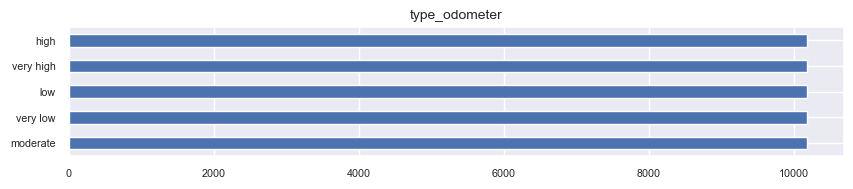

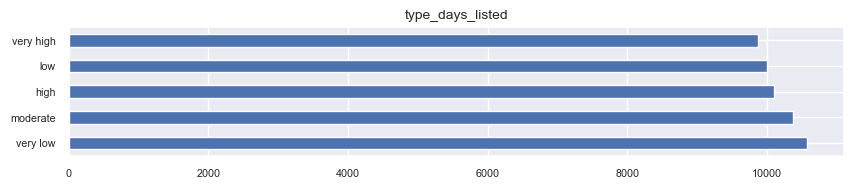

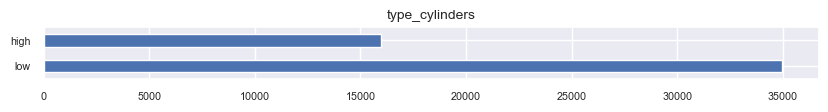

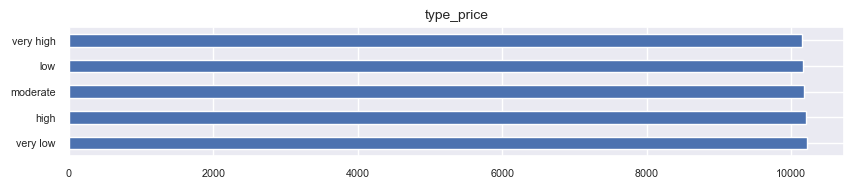

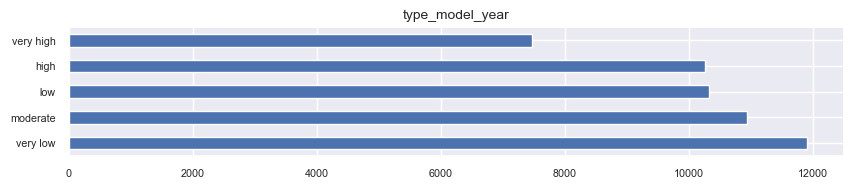

,price,model_year,model,condition,cylinders,odometer,type,paint_color,is_4wd,date_posted,days_listed,type_odometer,type_days_listed,type_cylinders,type_price,type_model_year
0,9400.0,2011,bmw,good,6,145000.0,SUV,white,True,2018-06-23,19,high,low,low,moderate,moderate
1,25500.0,2011,ford,good,6,88705.0,pickup,white,True,2018-10-19,50,low,high,low,very high,moderate
2,5500.0,2013,hyundai,like new,4,110000.0,sedan,red,False,2019-02-07,79,moderate,very high,low,low,high
3,1500.0,2003,ford,fair,8,113419.0,pickup,white,False,2019-03-22,9,moderate,very low,high,very low,very low
4,14900.0,2017,chrysler,excellent,4,80903.0,sedan,black,False,2019-04-02,28,low,moderate,low,high,very high


In [24]:
# Si no existe una clasificación brindada por el negocio, se realiza una agrupación natural (qcut-cut).
# Ejemplo:
#  Edad: [0-7): niño, [8-18): adolescente, [70-120]: 3ra edad


types_2 = ['low', 'high']
types_3 = ['low', 'normal', 'high']
types_5 = ['very low', 'low', 'moderate', 'high', 'very high']

pref = 'type_'  # Para optimizar los gráficos que de generarán a continuación.

# Columns created are added to delete later.
type_columns = [
    (f'{pref}odometer', 'odometer', types_5),
    (f'{pref}days_listed', 'days_listed', types_5),
    (f'{pref}cylinders', 'cylinders', types_2),
    (f'{pref}price', 'price', types_5),
    (f'{pref}model_year', 'model_year', types_5)]

for col in type_columns:
    plt.rcParams['figure.figsize'] = (10, len(col[2])/3)

    df[col[0]] = pd.qcut(x=df[col[1]], q=len(col[2]), labels=col[2])
#     df[col[0]] = pd.cut(x=df[col[1]], bins=len(col[2]), labels=col[2])

    df[col[0]].value_counts().plot(kind='barh')
    plt.title(col[0], fontsize=10)
    plt.show()

df.head()


In [25]:
date_columns = []

for col in df.select_dtypes(include=np.datetime64).columns:
    dw, d, m = f'{col}_day_of_week', f'{col}_day', f'{col}_month'
    date_columns = date_columns + [dw, d, m]

    df[dw] = pd.DatetimeIndex(df[col]).dayofweek.astype('category')
    df[d] = pd.DatetimeIndex(df[col]).day.astype('category')
    df[m] = pd.DatetimeIndex(df[col]).month.astype('category')

df.head()


,price,model_year,model,condition,cylinders,odometer,type,paint_color,is_4wd,date_posted,days_listed,type_odometer,type_days_listed,type_cylinders,type_price,type_model_year,date_posted_day_of_week,date_posted_day,date_posted_month
0,9400.0,2011,bmw,good,6,145000.0,SUV,white,True,2018-06-23,19,high,low,low,moderate,moderate,5,23,6
1,25500.0,2011,ford,good,6,88705.0,pickup,white,True,2018-10-19,50,low,high,low,very high,moderate,4,19,10
2,5500.0,2013,hyundai,like new,4,110000.0,sedan,red,False,2019-02-07,79,moderate,very high,low,low,high,3,7,2
3,1500.0,2003,ford,fair,8,113419.0,pickup,white,False,2019-03-22,9,moderate,very low,high,very low,very low,4,22,3
4,14900.0,2017,chrysler,excellent,4,80903.0,sedan,black,False,2019-04-02,28,low,moderate,low,high,very high,1,2,4


In [26]:
numeric_features = df.select_dtypes(np.number).columns.to_list()
continuous_features = df.select_dtypes(float).columns.to_list()
discrete_features = df.select_dtypes(int).columns.to_list()
categorical_features = df.select_dtypes('category').columns.to_list()
object_features = df.select_dtypes('object').columns.to_list()
bool_features = df.select_dtypes(bool).columns.to_list()
date_time_features = df.select_dtypes(np.datetime64).columns.to_list()
time_delta_features = df.select_dtypes(np.timedelta64).columns.to_list()

display({'numeric_features': ', '.join(numeric_features), 'continuous_features': ', '.join(continuous_features),
         'discrete_features': ', '.join(discrete_features), 'categorical_features': ', '.join(categorical_features),
         'object_features': ', '.join(object_features), 'bool_features': ', '.join(bool_features),
         'date_time_features': ', '.join(date_time_features), 'time_delta_features': ', '.join(time_delta_features)})


{'numeric_features': 'price, model_year, cylinders, odometer, days_listed',
 'continuous_features': 'price, odometer',
 'discrete_features': 'model_year, cylinders, days_listed',
 'categorical_features': 'model, condition, type, paint_color, type_odometer, type_days_listed, type_cylinders, type_price, type_model_year, date_posted_day_of_week, date_posted_day, date_posted_month',
 'object_features': '',
 'bool_features': 'is_4wd',
 'date_time_features': 'date_posted',
 'time_delta_features': ''}

## Statistical Summary

In [27]:
df.describe()


,price,model_year,cylinders,odometer,days_listed
count,50906.000000,50906.000000,50906.000000,50906.000000,50906.000000
mean,11628.662830,2010.077869,6.096256,114802.327329,37.971870
std,8579.559646,5.154517,1.572367,55830.874478,24.959511
min,1.000000,1992.000000,3.000000,0.000000,0.000000
25%,4999.000000,2007.000000,4.000000,80885.000000,19.000000
50%,8995.000000,2011.000000,6.000000,113419.000000,33.000000
75%,16000.000000,2014.000000,8.000000,146000.000000,52.000000
max,42000.000000,2019.000000,10.000000,310227.000000,124.000000


## Correlation

### Dispersion Diagram

In [28]:
@interact(hue=[None] + categorical_features + bool_features,
          size=[None] + numeric_features,
          n_samples=IntSlider(value=10000, min=10000, max=len(df), step=1000))
def _(hue, size, n_samples):

    if hue != None and len(df[hue].unique()) > 20:
        print(f'Too many categories: {hue}={df[hue].unique()}')
        return

    _df = df.sample(n=n_samples, replace=False, random_state=23)

    sns.pairplot(data=_df, hue=hue, size=size, diag_kind='hist')

    plt.show()


interactive(children=(Dropdown(description='hue', options=(None, 'model', 'condition', 'type', 'paint_color', …

In [29]:
@interact(x=numeric_features,
          y=numeric_features,
          hue=[None] + categorical_features + bool_features,
          size=[None] + numeric_features,
          style=[None] + categorical_features + bool_features,
          alpha=FloatSlider(value=1, min=.1, max=1, step=.1),
          show=fixed(True), file_name=fixed(''))
def my_relplot(x, y, hue, size, style, alpha, show, file_name):

    if hue != None and len(df[hue].unique()) > 50:
        if show == True:
            print(f'Too many categories: {hue}={df[hue].unique()}')

        return

    if style != None and len(df[style].unique()) > 50:
        if show == True:
            print(f'Too many categories: {style}={df[style].unique()}')

        return

    chart = sns.relplot(data=df, x=x, y=y, hue=hue, size=size,
                        style=style, alpha=alpha, height=6)

    plt.title(f'{x} vs {y}', fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.savefig(f'resources/EDA/{file_name}.png')
        plt.close()


interactive(children=(Dropdown(description='x', options=('price', 'model_year', 'cylinders', 'odometer', 'days…

In [30]:
@interact(x=numeric_features,
          y=categorical_features + bool_features,
          hue=[None] + categorical_features + bool_features,
          orient=['v', 'h'],
          n_samples=IntSlider(value=1000, min=1000, max=len(df), step=1000),
          show=fixed(True), file_name=fixed(''))
def my_swarmplot(x, y, hue, orient, n_samples, show, file_name):

    plt.rcParams['figure.figsize'] = (18, 6)

    if y == None:
        print('No existen variables categóricas o booleanas.')
        return

    if len(df[y].unique()) > 50:
        if show == True:
            print(f'Too many categories: {y}={df[y].unique()}')

        return

    if hue != None and len(df[hue].unique()) > 50:
        if show == True:
            print(f'Too many categories: {hue}={df[hue].unique()}')

        return

    _df = df.sample(n=n_samples, replace=True, random_state=23)

    if orient == 'v':
        x, y = y, x

    chart = sns.swarmplot(data=_df, x=x, y=y, hue=hue, orient=orient, size=3)

    plt.title(f'{y} by {x}', fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.get_figure().savefig(f'resources/EDA/{file_name}.png')
        plt.close()


interactive(children=(Dropdown(description='x', options=('price', 'model_year', 'cylinders', 'odometer', 'days…

### Pearson Correlation

In [31]:
@interact(show=fixed(True), file_name=fixed(''))
def my_pearson(show, file_name):

    plt.rcParams['figure.figsize'] = (10, 10)

    matrix = df.corr(method='pearson', numeric_only=True)
    chart = sns.heatmap(data=matrix, annot=True, square=True, center=0)
    chart.set_xticklabels(chart.get_xticklabels(),
                          rotation=45, horizontalalignment='right')

    plt.title('Pearson Diagram', fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.get_figure().savefig(f'resources/EDA/{file_name}.png')
        plt.close()


interactive(children=(Output(),), _dom_classes=('widget-interact',))

## Distributions

### Histogram

In [32]:
@interact(col=numeric_features,
          normal=False,
          stat=['count', 'frequency', 'probability', 'percent', 'density'],
          cumulative=False,
          hue=[None] + categorical_features + bool_features,
          kde=False,
          show=fixed(True), file_name=fixed(''))
def my_histplot(col, normal, stat, cumulative, hue, kde, show, file_name):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6),
                           gridspec_kw={'width_ratios': [1, .3]})

    # ax1 -----------------------------------------------------------------------------------

    if normal == False:
        if hue != None and len(df[hue].unique()) > 50:
            if show == True:
                print(f'Too many categories: {hue}={df[hue].unique()}')

            plt.close()
            return

        chart = sns.histplot(data=df, ax=ax[0], x=col, hue=hue, stat=stat,
                             multiple='stack', cumulative=cumulative, kde=kde)
        chart.set(title='Histogram')
    else:
        try:
            # Valores de la media (mu) y desviación típica (sigma) de los datos
            mu, sigma = stats.norm.fit(data=df[col])

            chart = sns.histplot(data=df, ax=ax[0], x=col, stat='density')

            # Valores teóricos de la normal en el rango observado
            x_hat = np.linspace(min(df[col]), max(df[col]), num=100)
            y_hat = stats.norm.pdf(x_hat, mu, sigma)

            ax[0].plot(x_hat, y_hat, 'r', linewidth=2, label='normal')
            ax[0].legend()
        except Exception as e:
            chart = sns.histplot(data=df, ax=ax[0], x=col, stat=stat)
            print('ax_0 error:', e)

    # ax2 -----------------------------------------------------------------------------------

    try:
        fig = sm.qqplot(df[col], fit=True, line='q', alpha=0.4, lw=2, ax=ax[1])
    except Exception as e:
        print('ax_1 error:', e)

    # ---------------------------------------------------------------------------------------

    if show == False:
        chart.get_figure().savefig(f'resources/EDA/{file_name}.png')
        plt.close()
        return

    kurtosis, skew = stats.kurtosis(df[col]), stats.skew(df[col])
    kurtosis, skew = round(kurtosis, 2), round(skew, 2)

    if skew < -1 or skew > 1:
        print(f'- La distribución está muy sesgada (skew={skew}).')
    elif -1 <= skew < -0.5 or 0.5 < skew <= 1:
        print(f'- La distribución está moderadamente sesgada (skew={skew}).')
    elif -0.5 <= skew <= 0.5:
        print(f'- La distribución es aproximadamente simétrica (skew={skew}).')

    if kurtosis < -0.5:
        print(
            f'- La distribución platicúrtica (kurtosis={kurtosis}), ', end='')
        print('existe una baja concentración de los valores en torno a su media.')
    if kurtosis > 0.5:
        print(f'- La distribución leptocúrtica (kurtosis={kurtosis}) ', end='')
        print('existe una gran concentración de los valores en torno a su media.')
    if -0.5 <= kurtosis <= 0.5:
        print(f'- La distribución mesocúrtica (kurtosis={kurtosis}) ', end='')
        print('existe una concentración normal de los valores en torno a su media.')

    plt.show()


interactive(children=(Dropdown(description='col', options=('price', 'model_year', 'cylinders', 'odometer', 'da…

### Probability Mass Function (PMF)

In [33]:
@interact(column=discrete_features, normalize=False)
def my_pmf(column, normalize):

    if column == None:
        print('No existen variables discretas.')
        return

    plt.rcParams['figure.figsize'] = (10, 6)

    data = df[column].value_counts(normalize=normalize)

    data = pd.DataFrame({'INDEX': data.index,
                         'VALUE': data.values}).sort_values(by=['INDEX'])

    plt.plot(data['INDEX'], data['VALUE'], '--')
    plt.vlines(data['INDEX'], 0, data['VALUE'], colors='b', lw=5, alpha=0.5)

    plt.title('Función de Masa de Probabilidad', fontsize=12)
    plt.ylabel('Density' if normalize else 'Count')
    plt.xlabel(column)
    plt.show()


interactive(children=(Dropdown(description='column', options=('model_year', 'cylinders', 'days_listed'), value…

In [34]:
@interact(x=numeric_features,
          y=numeric_features,
          hue=[None] + categorical_features + bool_features,
          kind=['scatter', 'kde', 'hist', 'hex', 'reg', 'resid'],
          show=fixed(True), file_name=fixed(''))
def my_jointplot(x, y, hue, kind, show, file_name):

    if hue != None and len(df[hue].unique()) > 50:
        if show == True:
            print(f'Too many categories: {hue}={df[hue].unique()}')

        return

    chart = sns.jointplot(data=df, x=x, y=y, hue=hue, kind=kind, height=6)

    if show == True:
        plt.show()
    else:
        chart.savefig(f'resources/EDA/{file_name}.png')
        plt.close()


interactive(children=(Dropdown(description='x', options=('price', 'model_year', 'cylinders', 'odometer', 'days…

### Box - Violin Plot

In [35]:
@interact(col=[None] + numeric_features,
          violin=False,
          orient=['v', 'h'],
          show=fixed(True), file_name=fixed(''))
def my_boxplot(col, violin, orient, show, file_name):

    if col is None:
        plt.rcParams['figure.figsize'] = (16, 8)
    else:
        plt.rcParams['figure.figsize'] = (6, 2)

    if violin:
        chart = sns.violinplot(data=df, x=col, orient=orient)
        plt.title('Violin Plot', fontsize=12)
    else:
        chart = sns.boxplot(data=df, x=col, orient=orient)
        plt.title('Box Plot', fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.get_figure().savefig(f'resources/EDA/{file_name}.png')
        plt.close()


interactive(children=(Dropdown(description='col', options=(None, 'price', 'model_year', 'cylinders', 'odometer…

In [36]:
@interact(x=categorical_features + bool_features,
          y=numeric_features,
          hue=[None] + bool_features,
          violin=False,
          split=False,
          orient=['v', 'h'],
          show_points=False,
          show=fixed(True), file_name=fixed(''))
def my_violinplot(x, y, hue, violin, split, orient, show_points, show, file_name):

    if x == None:
        print('No existen variables categóricas o booleanas.')
        return

    if len(df[x].unique()) > 50:
        if show == True:
            print(f'Too many categories: {x}={df[x].unique()}')

        return

    x_org = x
    if orient == 'h':
        x, y = y, x

    if show_points == True:
        chart = sns.stripplot(data=df, x=x, y=y, color='.3', size=3)

    plt.rcParams['figure.figsize'] = (10, 6)

    if violin:
        chart = sns.violinplot(x=x, y=y, data=df, hue=hue,
                               split=split, orient=orient)
        plt.title(f'Violin Plot by {x_org}', fontsize=12)
    else:
        chart = sns.boxplot(x=x, y=y, data=df, hue=hue, orient=orient)
        plt.title(f'Box Plot by {x_org}', fontsize=12)

    sns.despine(offset=10, trim=True)

    if show == True:
        plt.show()
    else:
        chart.get_figure().savefig(f'resources/EDA/{file_name}.png')
        plt.close()


interactive(children=(Dropdown(description='x', options=('model', 'condition', 'type', 'paint_color', 'type_od…

## Contingency Table

In [37]:
@interact(index=categorical_features + bool_features,
          columns=categorical_features + bool_features,
          values=numeric_features,
          annot=False,
          agg_func=['count', 'mean', 'median', 'sum', 'std', 'probability'],
          show=fixed(True), file_name=fixed(''))
def my_contingency(index, columns, values, annot, agg_func, show, file_name):

    plt.rcParams['figure.figsize'] = (8, 8)

    if index == None:
        print('No existen variables categóricas.')
        return

    if index == columns:
        sns.displot(data=df, x=index)
        plt.show()
        return

    if len(df[index].unique()) > 50:
        if show == True:
            print(f'Too many categories: {index}={df[index].unique()}')

        return

    if len(df[columns].unique()) > 50:
        if show == True:
            print(f'Too many categories: {columns}={df[columns].unique()}')

        return

    agg_func_aux = 'count' if agg_func == 'probability' else agg_func
    contingency_table = df.pivot_table(index=index, columns=columns, values=values,
                                       aggfunc=agg_func_aux, fill_value=0).dropna(axis=0, how='all')

#     display(contingency_table)

    if agg_func == 'probability':
        contingency_table = contingency_table.astype(float).div(contingency_table.sum(axis=1),
                                                                axis=0)
        fmt = '.2%'
    else:
        fmt = 'g'

    chart = sns.heatmap(data=contingency_table,
                        annot=annot, fmt=fmt, square=True)
    chart.set_xticklabels(chart.get_xticklabels(),
                          rotation=45, horizontalalignment='right')

    if agg_func == 'count':
        plt.title(f'Contingency Table ({agg_func})', fontsize=12)
    else:
        plt.title(f'Contingency Table ({agg_func} {values})', fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.get_figure().savefig(f'resources/EDA/{file_name}.png')
        plt.close()


interactive(children=(Dropdown(description='index', options=('model', 'condition', 'type', 'paint_color', 'typ…

## Statistics

In [38]:
@interact(x=categorical_features + bool_features,
          y=numeric_features,
          hue=[None] + categorical_features + bool_features,
          estimator=['mean', 'count', 'median', 'sum', 'std'],
          kind=['bar', 'strip', 'box', 'violin', 'boxen', 'point'],
          orient=['v', 'h'],
          show=fixed(True), file_name=fixed(''))
def my_catplot(x, y, hue, estimator, kind, orient, show, file_name):

    if x == None:
        print('No existen variables categóricas.')
        return

    if len(df[x].unique()) > 50:
        if show == True:
            print(f'Too many categories: {x}={df[x].unique()}')

        return

    if hue != None and len(df[hue].unique()) > 5:
        if show == True:
            print(f'Too many categories: {hue}={df[hue].unique()}')

        return

    if orient == 'h':
        x, y = y, x

    chart = sns.catplot(data=df, x=x, y=y, hue=hue, estimator=estimator, kind=kind,
                        orient=orient, errorbar=None, height=6, aspect=2.5)
    chart.despine(left=True)

    if estimator == 'count':
        chart.set(ylabel='count')

    plt.title(f'Statistics ({estimator})', fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.savefig(f'resources/EDA/{file_name}.png')
        plt.close()


interactive(children=(Dropdown(description='x', options=('model', 'condition', 'type', 'paint_color', 'type_od…

In [39]:
@interact(col=categorical_features, show=fixed(True), file_name=fixed(''))
def my_pie(col, show, file_name):

    if col == None:
        print('No existen variables categóricas.')
        return

    plt.rcParams['figure.figsize'] = (8, 8)

    labels = df[col].value_counts().index.values
    sizes = df[col].value_counts().values
    explode = np.full(df[col].value_counts().count(), 0.1)

    _, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels,
            autopct='%1.1f%%', shadow=True, startangle=90)
    # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.axis('equal')

    plt.title(f'{col}', fontsize=12)

    if show == True:
        plt.show()
    else:
        plt.savefig(f'resources/EDA/{file_name}.png')
        plt.close()


interactive(children=(Dropdown(description='col', options=('model', 'condition', 'type', 'paint_color', 'type_…

## Time

In [40]:
@interact(x=date_time_features,
          y=numeric_features,
          agg_func=['count', 'mean', 'median', 'sum'],
          hue=[None] + categorical_features + bool_features,
          style=0,
          show=fixed(True), file_name=fixed(''))
def my_lineplot(x, y, agg_func, hue, style, show, file_name):
    if x == None:
        print('No existen variables de tiempo.')
        return

    if hue is not None and len(df[hue].unique()) > 20:
        if show == True:
            print(f'Too many categories: {hue}={df[hue].unique()}')

        return

    plt.figure(figsize=(18, 8))

    by = [hue, x] if hue is not None else x
    data = df.groupby(by)[y].agg(agg_func).reset_index()

#     display(data.head())

    chart = sns.lineplot(data=data, x=x, y=y, hue=hue,
                         style=hue if style == True else None, linewidth=0.5)

    if agg_func == 'count':
        chart.set(ylabel='count')

    plt.title(f'Daily ({agg_func})', fontsize=12)

    if show == True:
        plt.show()
    else:
        chart.get_figure().savefig(f'resources/EDA/{file_name}.png')
        plt.close()


interactive(children=(Dropdown(description='x', options=('date_posted',), value='date_posted'), Dropdown(descr…

## Map

In [41]:
#


Se pueden generar los principales gráficos en la carpeta `EDA` para luego analizarlos.

In [42]:
# El multihilo no funciona más rápido y tiene problemas al pintar los gráficos.

# False: Calcula la cantidad de imágenes aproximadas que se generarán.
# True: Genera las imágenes (demora más).
paint = False

count = 0

print(f'Step 01: {count} generated graphs.')

for i, x in enumerate(numeric_features):
    for j, y in enumerate(numeric_features):
        if j <= i:
            continue

        for hue in [None] + categorical_features + bool_features:
            if hue in [f'type_{x}', f'type_{y}']:
                continue

            if paint == True:
                my_relplot(x, y, hue, size=None, style=None, alpha=1,
                           show=False, file_name=str(count).zfill(5))

            count += 1

print(f'Step 02: {count} generated graphs.')

for x in numeric_features:
    for y in categorical_features + bool_features:
        for hue in [None] + categorical_features + bool_features:

            if f'type_{x}' in [y, hue] or y == hue:
                continue

            if paint == True:
                my_swarmplot(x, y, hue, orient='v', n_samples=1000,
                             show=False, file_name=str(count).zfill(5))

            count += 1

print(f'Step 03: {count} generated graphs.')

if paint == True:
    my_pearson(show=False, file_name=str(count).zfill(5))
    count += 1

print(f'Step 04: {count} generated graphs.')

for col in numeric_features:
    if paint == True:
        my_histplot(col, normal=False, stat='count', cumulative=False, hue=None, kde=False,
                    show=False, file_name=str(count).zfill(5))

    count += 1

print(f'Step 05: {count} generated graphs.')

for col in [None] + numeric_features:
    for violin in [False, True]:
        if paint == True:
            my_boxplot(col, violin, orient='v', show=False,
                       file_name=str(count).zfill(5))

        count += 1

print(f'Step 06: {count} generated graphs.')

for x in categorical_features + bool_features:
    for y in numeric_features:
        for hue in [None] + bool_features:
            if paint == True:
                my_violinplot(x, y, hue, violin=False, split=False, orient='v', show_points=False,
                              show=False, file_name=str(count).zfill(5))

            count += 1

print(f'Step 07: {count} generated graphs.')

for i, index in enumerate(categorical_features + bool_features):
    for j, columns in enumerate(categorical_features + bool_features):
        if j <= i:
            continue

        # Para my_contingency con agg_func='count' se obtienen los mismos resultados sin importar el values seleccionado.
        if paint == True:
            my_contingency(index, columns, values=numeric_features[0], annot=True, agg_func='count',
                           show=False, file_name=str(count).zfill(5))

        count += 1

        for k, values in enumerate(numeric_features):
            if paint == True:
                my_contingency(index, columns, values, annot=True, agg_func='mean',
                               show=False, file_name=str(count).zfill(5))

            count += 1

print(f'Step 08: {count} generated graphs.')

for x in categorical_features + bool_features:
    for y in numeric_features:
        for hue in [None] + categorical_features + bool_features:
            if f'type_{y}' in [x, hue] or x == hue:
                continue

            if paint == True:
                my_catplot(x, y, hue, estimator='mean', kind='bar', orient='v',
                           show=False, file_name=str(count).zfill(5))

            count += 1

print(f'Step 09: {count} generated graphs.')

for col in categorical_features:
    if paint == True:
        my_pie(col, show=False, file_name=str(count).zfill(5))

    count += 1

print(f'Step 10: {count} generated graphs.')

for x in date_time_features:
    if len(numeric_features) > 0:
        y = numeric_features[0]

        for hue in [None] + categorical_features + bool_features:
            if paint == True:
                my_lineplot(x, y, agg_func='count', hue=hue, style=False,
                            show=False, file_name=str(count).zfill(5))

            count += 1

    for y in numeric_features:
        for hue in [None] + categorical_features + bool_features:
            if paint == True:
                my_lineplot(x, y, agg_func='mean', hue=hue, style=False,
                            show=False, file_name=str(count).zfill(5))

            count += 1

print(f'Step 11: {count} generated graphs.')


Step 01: 0 generated graphs.
Step 02: 120 generated graphs.
Step 03: 840 generated graphs.
Step 04: 840 generated graphs.
Step 05: 845 generated graphs.
Step 06: 857 generated graphs.
Step 07: 987 generated graphs.
Step 08: 1455 generated graphs.
Step 09: 2175 generated graphs.
Step 10: 2187 generated graphs.
Step 11: 2271 generated graphs.


- Conclusión 1.
- Conclusión 2.
- Conclusión 3.
- Conclusión 4.
- Conclusión 5.

Se eliminan las columnas categóricas creadas anteriormente.

In [43]:
df.drop(labels=[t[0] for t in type_columns], axis=1, inplace=True)
df.drop(labels=date_columns, axis=1, inplace=True)


In [44]:
del numeric_features, continuous_features, discrete_features, categorical_features, object_features, bool_features, date_time_features, time_delta_features


# Machine Learning

## Preprocess

In [45]:
preprocessor_resume = pd.DataFrame(data=df.dtypes, columns=['TYPE'])
preprocessor_resume['VALUES'] = preprocessor_resume.apply(lambda x: df[x.name].unique(),
                                                          axis=1)
preprocessor_resume['VALUES_LEN'] = preprocessor_resume.apply(lambda x: len(df[x.name].unique()),
                                                              axis=1)
preprocessor_resume[['TRANSFORMER', 'STATE']] = 'UNKNOWN'
# ------------------------------------------------------------------------------------------------------------------
standard_feat = ['model_year', 'cylinders', 'odometer', 'days_listed']
one_hot_feat = ['model', 'type', 'paint_color', 'is_4wd']
ordinal_feat = ['condition']

preprocessor_resume.loc[standard_feat, 'TRANSFORMER'] = 'STANDARD_SCALER'
preprocessor_resume.loc[one_hot_feat, 'TRANSFORMER'] = 'ONE_HOT_ENCODER'
preprocessor_resume.loc[ordinal_feat, 'TRANSFORMER'] = 'ORDINAL_ENCODER'
# ------------------------------------------------------------------------------------------------------------------
condition_cat = [['new', 'like new', 'excellent', 'good', 'fair', 'salvage']]

preprocessor = ColumnTransformer(transformers=[('standard',
                                                StandardScaler(), standard_feat),
                                               ('one_hot',
                                                OneHotEncoder(sparse_output=True, drop='first'), one_hot_feat),
                                               ('condition',
                                                OrdinalEncoder(categories=condition_cat), ['condition'])])

preprocessor_resume.loc[standard_feat + one_hot_feat + ordinal_feat,
                        'STATE'] = 'OK'
# ------------------------------------------------------------------------------------------------------------------
X = preprocessor.fit_transform(X=df)

features_out = [f.split('__')[1] for f in preprocessor.get_feature_names_out()]
print('features_out:', ', '.join(features_out))

display(preprocessor)
display(preprocessor_resume)

print(f'Dimensiones de los datos: {X.shape}.')
del X


features_out: model_year, cylinders, odometer, days_listed, model_bmw, model_buick, model_cadillac, model_chevrolet, model_chrysler, model_dodge, model_ford, model_gmc, model_honda, model_hyundai, model_jeep, model_kia, model_mercedes-benz, model_nissan, model_ram, model_subaru, model_toyota, model_volkswagen, type_bus, type_convertible, type_coupe, type_hatchback, type_mini-van, type_offroad, type_other, type_pickup, type_sedan, type_truck, type_van, type_wagon, paint_color_blue, paint_color_brown, paint_color_custom, paint_color_green, paint_color_grey, paint_color_orange, paint_color_purple, paint_color_red, paint_color_silver, paint_color_white, paint_color_yellow, is_4wd_True, condition


ColumnTransformer(transformers=[('standard', StandardScaler(),
                                 ['model_year', 'cylinders', 'odometer',
                                  'days_listed']),
                                ('one_hot', OneHotEncoder(drop='first'),
                                 ['model', 'type', 'paint_color', 'is_4wd']),
                                ('condition',
                                 OrdinalEncoder(categories=[['new', 'like new',
                                                             'excellent',
                                                             'good', 'fair',
                                                             'salvage']]),
                                 ['condition'])])

,TYPE,VALUES,VALUES_LEN,TRANSFORMER,STATE
price,float64,"[9400.0, 25500.0, 5500.0, 1500.0, 14900.0, 149...",3217,UNKNOWN,UNKNOWN
model_year,int32,"[2011, 2013, 2003, 2017, 2014, 2015, 2012, 200...",28,STANDARD_SCALER,OK
model,category,"['bmw', 'ford', 'hyundai', 'chrysler', 'toyota...",19,ONE_HOT_ENCODER,OK
condition,category,"['good', 'like new', 'fair', 'excellent', 'sal...",6,ORDINAL_ENCODER,OK
cylinders,int32,"[6, 4, 8, 5, 10, 3]",6,STANDARD_SCALER,OK
odometer,float64,"[145000.0, 88705.0, 110000.0, 113419.0, 80903....",17397,STANDARD_SCALER,OK
type,category,"['SUV', 'pickup', 'sedan', 'truck', 'coupe', ....",13,ONE_HOT_ENCODER,OK
paint_color,category,"['white', 'red', 'black', 'blue', 'grey', ...,...",12,ONE_HOT_ENCODER,OK
is_4wd,bool,"[True, False]",2,ONE_HOT_ENCODER,OK
date_posted,datetime64[ns],"[2018-06-23T00:00:00.000000000, 2018-10-19T00:...",354,UNKNOWN,UNKNOWN


Dimensiones de los datos: (50906, 47).


- Se reversan a los valores antes de realizar las transformaciones.
- El transformer será incluido en el modelo.

In [46]:
df = df_bk.copy()
df.head()


,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011.0,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19
1,25500,NaN,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
2,5500,2013.0,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,NaN,2019-02-07,79
3,1500,2003.0,ford f-150,fair,8.0,gas,NaN,automatic,pickup,NaN,NaN,2019-03-22,9
4,14900,2017.0,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,NaN,2019-04-02,28


Se defnine el `target`.

In [47]:
targets = df[target_column]
targets.shape


(50906,)

## Cross Validation

In [48]:
results = pd.DataFrame(columns=['TYPE', 'POLY_DEGREE', 'SCORE', 'ESTIMATOR'])


def my_grid_search_cv(model, X, y, results, param_grid, poly_degrees):
    estimators = []

    for degree in poly_degrees:
        steps = [('transformer', VehiclesDataTransformer()),
                 ('outlier', VehiclesOutlierTransformer()),
                 ('imputer', VehiclesImputeTransformer()),
                 ('preprocessor', preprocessor),
                 ('polynomial', PolynomialFeatures(degree=degree)),
                 ('model', model)]

        pipe = Pipeline(steps=steps)

        target_transformer = MinMaxScaler(feature_range=(0, 1))
        sklearn_estimator = TransformedTargetRegressor(regressor=pipe,
                                                       transformer=target_transformer)

        grid_search = GridSearchCV(estimator=sklearn_estimator, param_grid=param_grid,
                                   scoring='neg_mean_absolute_error', cv=10, n_jobs=-1, return_train_score=True)
        grid_search.fit(X, y)
        estimator = grid_search.best_estimator_
        estimators.append(estimator)

        score = round(grid_search.best_score_, 4)
        display(estimator)
        model_name = str(model).split('(')[0]
        print(
            f'The model {model_name} has a prediction error of +-{-score} dollars.')

        results.loc[model_name] = {'TYPE': 'ML', 'POLY_DEGREE': degree,
                                   'SCORE': score, 'ESTIMATOR': estimator}

    return (results,) + tuple(estimators)


## Linear Regression

In [49]:
results, ols = my_grid_search_cv(model=LinearRegression(), X=df, y=targets, results=results,
                                 param_grid={}, poly_degrees=[1])
results


TransformedTargetRegressor(regressor=Pipeline(steps=[('transformer',
                                                      VehiclesDataTransformer()),
                                                     ('outlier',
                                                      VehiclesOutlierTransformer()),
                                                     ('imputer',
                                                      VehiclesImputeTransformer()),
                                                     ('preprocessor',
                                                      ColumnTransformer(transformers=[('standard',
                                                                                       StandardScaler(),
                                                                                       ['model_year',
                                                                                        'cylinders',
                                                                                        'odometer',
                                                                                        'days_listed']),
                                                                                      ('one_hot',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['model',
                                                                                        'type',
                                                                                        'paint_color',
                                                                                        'is_4wd']),
                                                                                      ('condition',
                                                                                       OrdinalEncoder(categories=[['new',
                                                                                                                   'like '
                                                                                                                   'new',
                                                                                                                   'excellent',
                                                                                                                   'good',
                                                                                                                   'fair',
                                                                                                                   'salvage']]),
                                                                                       ['condition'])])),
                                                     ('polynomial',
                                                      PolynomialFeatures(degree=1)),
                                                     ('model',
                                                      LinearRegression())]),
                           transformer=MinMaxScaler())

The model LinearRegression has a prediction error of +-3962.1433 dollars.


,TYPE,POLY_DEGREE,SCORE,ESTIMATOR
LinearRegression,ML,1,-3962.1433,TransformedTargetRegressor(regressor=Pipeline(...


## Regularization

### Lasso

In [50]:
param_grid = {'regressor__model__alpha': np.linspace(0.1, 1.0, 10)}
results, lasso = my_grid_search_cv(model=Lasso(), X=df, y=targets, results=results,
                                   param_grid=param_grid, poly_degrees=[1])
results


TransformedTargetRegressor(regressor=Pipeline(steps=[('transformer',
                                                      VehiclesDataTransformer()),
                                                     ('outlier',
                                                      VehiclesOutlierTransformer()),
                                                     ('imputer',
                                                      VehiclesImputeTransformer()),
                                                     ('preprocessor',
                                                      ColumnTransformer(transformers=[('standard',
                                                                                       StandardScaler(),
                                                                                       ['model_year',
                                                                                        'cylinders',
                                                                                        'odometer',
                                                                                        'days_listed']),
                                                                                      ('one_hot',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['model',
                                                                                        'type',
                                                                                        'paint_color',
                                                                                        'is_4wd']),
                                                                                      ('condition',
                                                                                       OrdinalEncoder(categories=[['new',
                                                                                                                   'like '
                                                                                                                   'new',
                                                                                                                   'excellent',
                                                                                                                   'good',
                                                                                                                   'fair',
                                                                                                                   'salvage']]),
                                                                                       ['condition'])])),
                                                     ('polynomial',
                                                      PolynomialFeatures(degree=1)),
                                                     ('model',
                                                      Lasso(alpha=0.1))]),
                           transformer=MinMaxScaler())

The model Lasso has a prediction error of +-6756.3223 dollars.


,TYPE,POLY_DEGREE,SCORE,ESTIMATOR
LinearRegression,ML,1,-3962.1433,TransformedTargetRegressor(regressor=Pipeline(...
Lasso,ML,1,-6756.3223,TransformedTargetRegressor(regressor=Pipeline(...


### Ridge

In [51]:
param_grid = {'regressor__model__alpha': np.linspace(0.1, 1.0, 10)}
results, ridge = my_grid_search_cv(model=Ridge(), X=df, y=targets, results=results,
                                   param_grid=param_grid, poly_degrees=[1])
results


TransformedTargetRegressor(regressor=Pipeline(steps=[('transformer',
                                                      VehiclesDataTransformer()),
                                                     ('outlier',
                                                      VehiclesOutlierTransformer()),
                                                     ('imputer',
                                                      VehiclesImputeTransformer()),
                                                     ('preprocessor',
                                                      ColumnTransformer(transformers=[('standard',
                                                                                       StandardScaler(),
                                                                                       ['model_year',
                                                                                        'cylinders',
                                                                                        'odometer',
                                                                                        'days_listed']),
                                                                                      ('one_hot',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['model',
                                                                                        'type',
                                                                                        'paint_color',
                                                                                        'is_4wd']),
                                                                                      ('condition',
                                                                                       OrdinalEncoder(categories=[['new',
                                                                                                                   'like '
                                                                                                                   'new',
                                                                                                                   'excellent',
                                                                                                                   'good',
                                                                                                                   'fair',
                                                                                                                   'salvage']]),
                                                                                       ['condition'])])),
                                                     ('polynomial',
                                                      PolynomialFeatures(degree=1)),
                                                     ('model',
                                                      Ridge(alpha=0.5))]),
                           transformer=MinMaxScaler())

The model Ridge has a prediction error of +-3961.9898 dollars.


,TYPE,POLY_DEGREE,SCORE,ESTIMATOR
LinearRegression,ML,1,-3962.1433,TransformedTargetRegressor(regressor=Pipeline(...
Lasso,ML,1,-6756.3223,TransformedTargetRegressor(regressor=Pipeline(...
Ridge,ML,1,-3961.9898,TransformedTargetRegressor(regressor=Pipeline(...


### ElasticNet

In [52]:
param_grid = {'regressor__model__alpha': np.linspace(0.1, 1.0, 10)}
results, elastic_net = my_grid_search_cv(model=ElasticNet(), X=df, y=targets, results=results,
                                         param_grid=param_grid, poly_degrees=[1])
results


The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


TransformedTargetRegressor(regressor=Pipeline(steps=[('transformer',
                                                      VehiclesDataTransformer()),
                                                     ('outlier',
                                                      VehiclesOutlierTransformer()),
                                                     ('imputer',
                                                      VehiclesImputeTransformer()),
                                                     ('preprocessor',
                                                      ColumnTransformer(transformers=[('standard',
                                                                                       StandardScaler(),
                                                                                       ['model_year',
                                                                                        'cylinders',
                                                                                        'odometer',
                                                                                        'days_listed']),
                                                                                      ('one_hot',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['model',
                                                                                        'type',
                                                                                        'paint_color',
                                                                                        'is_4wd']),
                                                                                      ('condition',
                                                                                       OrdinalEncoder(categories=[['new',
                                                                                                                   'like '
                                                                                                                   'new',
                                                                                                                   'excellent',
                                                                                                                   'good',
                                                                                                                   'fair',
                                                                                                                   'salvage']]),
                                                                                       ['condition'])])),
                                                     ('polynomial',
                                                      PolynomialFeatures(degree=1)),
                                                     ('model',
                                                      ElasticNet(alpha=0.1))]),
                           transformer=MinMaxScaler())

The model ElasticNet has a prediction error of +-5744.8384 dollars.


,TYPE,POLY_DEGREE,SCORE,ESTIMATOR
LinearRegression,ML,1,-3962.1433,TransformedTargetRegressor(regressor=Pipeline(...
Lasso,ML,1,-6756.3223,TransformedTargetRegressor(regressor=Pipeline(...
Ridge,ML,1,-3961.9898,TransformedTargetRegressor(regressor=Pipeline(...
ElasticNet,ML,1,-5744.8384,TransformedTargetRegressor(regressor=Pipeline(...


## Decision Trees

In [53]:
# param_grid = {'regressor__model__max_depth': range(1, 20),
#               'regressor__model__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']}
# results, decision_tree_regressor = my_grid_search_cv(model=DecisionTreeRegressor(), X=df, y=targets,
#                                                      results=results, param_grid=param_grid, poly_degrees=[1])
# results


## Support Vector Machines (SVM)

In [54]:
# param_grid = {'regressor__model__kernel': ['linear', 'poly', 'sigmoid', 'rbf'],  # Allows transformation to higher levels.
#               # Border complexity: linear, curved.
#               'regressor__model__gamma': [1e-3, 1e-2, 0.1],
#               'regressor__model__C': [1, 10, 100]}          # Controls the tradeoff between training errors and hard margins.
# results, svr = my_grid_search_cv(model=SVR(), X=df, y=targets, results=results,
#                                  param_grid=param_grid, poly_degrees=[1])
# results


## K Nearest Neighbors

In [55]:
# param_grid = {'regressor__model__n_neighbors': range(3, 20, 2),
#               'regressor__model__metric': ['euclidean', 'manhattan', 'chebyshev']}
# results, k_neighbors_regressor = my_grid_search_cv(model=KNeighborsRegressor(), X=df, y=targets, results=results,
#                                                    param_grid=param_grid, poly_degrees=[1])
# results


## Naive Bayes

In [56]:
# results, bayesian_ridge = my_grid_search_cv(model=BayesianRidge(), X=df, y=targets, results=results,
#                                             param_grid={}, poly_degrees=[1])
# results


## Ensemble Methods

### Bagging

In [57]:
# param_grid = {'regressor__model__estimator': [LinearRegression(), Lasso(), Ridge(), ElasticNet(), DecisionTreeRegressor(),
#                                               SVR(), KNeighborsRegressor(), BayesianRidge()],
#               'regressor__model__n_estimators': range(1, 21)}
# results, bagging_regressor = my_grid_search_cv(model=BaggingRegressor(), X=df, y=targets, results=results,
#                                                param_grid=param_grid, poly_degrees=[1])
# results


### Boosting

In [58]:
# param_grid = {'regressor__model__estimator': [LinearRegression(), Lasso(), Ridge(), ElasticNet(), DecisionTreeRegressor(),
#                                               SVR(), KNeighborsRegressor(), BayesianRidge()],
#               'regressor__model__n_estimators': range(1, 21)}
# results, bagging_regressor = my_grid_search_cv(model=AdaBoostRegressor(), X=df, y=targets, results=results,
#                                                param_grid=param_grid, poly_degrees=[1])
# results


### Gradient Boosting (GBRT)

In [59]:
# param_grid = {'regressor__model__n_estimators': range(1, 21)}
# results, gradient_boosting_regressor = my_grid_search_cv(model=GradientBoostingRegressor(), X=df, y=targets,
#                                                          results=results, param_grid=param_grid, poly_degrees=[1])
# results


### Random Forests

In [60]:
# param_grid = {'regressor__model__n_estimators': range(1, 21)}
# results, random_forest_regressor = my_grid_search_cv(model=RandomForestRegressor(), X=df, y=targets,
#                                                      results=results, param_grid=param_grid, poly_degrees=[1])
# results


## Learning Curves

In [61]:
train_sizes, train_scores, test_scores = learning_curve(ols, df, targets, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error',
                                                        train_sizes=np.linspace(0.01, 1., 10))
train_sizes.shape, train_scores.shape, test_scores.shape


((10,), (10, 5), (10, 5))

In [62]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_mean


array([-3620.50708695, -3976.49171851, -3974.9649235 , -4120.78080764,
       -4131.57268837, -4084.4022776 , -4031.50770975, -4009.1732963 ,
       -3972.24824709, -3947.21081503])

In [63]:
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_mean


array([           nan, -4143.39123685, -4053.79077284, -4028.04605524,
       -4024.15540751, -4001.37678051, -3986.54490303, -3981.01717129,
       -3972.77146132, -3969.24814031])

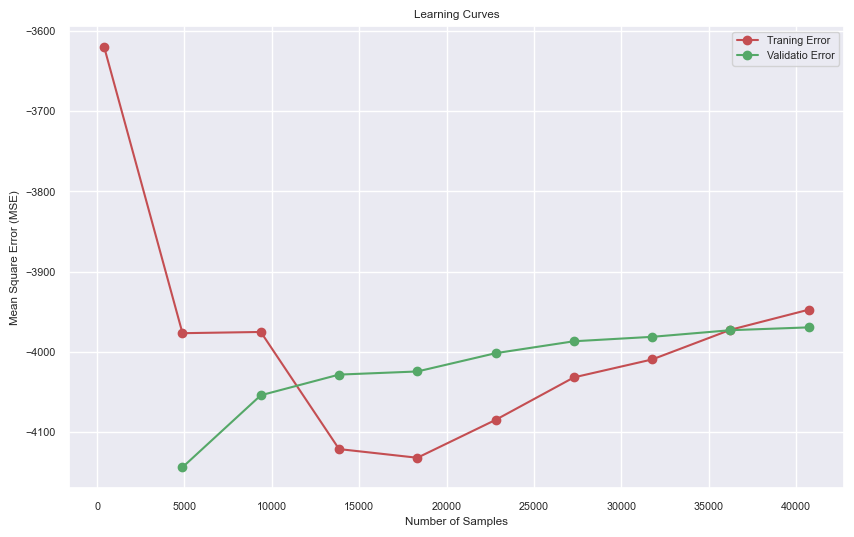

In [64]:
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.rc('figure', figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-',
         color='r', label='Traning Error')
plt.plot(train_sizes, test_scores_mean, 'o-',
         color='g', label='Validatio Error')

plt.title('Learning Curves')
plt.xlabel('Number of Samples')
plt.ylabel('Mean Square Error (MSE)')

plt.legend()


Shortcode for all estimators.

In [65]:
@interact(model=results.index, results=fixed(results))
def _(model, results):
    plt.rc('figure', figsize=(10, 6))

    train_sizes, train_scores, test_scores = learning_curve(results.loc[model].ESTIMATOR, df, targets, cv=5,
                                                            n_jobs=-1, train_sizes=np.linspace(0.01, 1., 10),
                                                            scoring='neg_mean_absolute_error')

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, 'o-',
             color='r', label='Traning error')
    plt.plot(train_sizes, test_scores_mean, 'o-',
             color='g', label='Validatio error')

    plt.title(f'Learning Curves: {model}')
    plt.xlabel('Number of Samples')
    plt.ylabel('Mean Square Error (MSE)')

    plt.legend()
    plt.show()


interactive(children=(Dropdown(description='model', options=('LinearRegression', 'Lasso', 'Ridge', 'ElasticNet…

## Validation Curves

Los hiperparámetros ya fueron seleccionados en cada uno de los algoritmos mediante `GridSearchCV`.

# Deep Learning

Cuda version.

In [66]:
print(f'Tensorflow version: {tf.__version__}')
print(f"Cuda version: {build.build_info['cuda_version']}")
print(f"Cudnn version: {build.build_info['cudnn_version']}")


Tensorflow version: 2.6.0
Cuda version: 64_113
Cudnn version: 64_8


**Enable GPU**

- The environment must be created with a version of Python compatible with the operation of Tensorflow and its use of the GPU (https://www.tensorflow.org/install/pip#virtual-environment-install).
- Before installing tensorflow-gpu you must install CUDA Toolkit and cuDNN from official NVIDIA site.
- Anaconda must be restarted after installing tensorflow-gpu.

In [67]:
# !conda install -y tensorflow-gpu keras-gpu

if len(tf.config.list_physical_devices('GPU')) == 0:
    raise SystemExit('Restart Anaconda to activate the GPU.')
else:
    print('GPU activated.')


GPU activated.


Available hardware.

In [68]:
tf.config.get_visible_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Available hardware details.

In [69]:
device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17447213840310472665,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2236245607
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3901330858999904895
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"]

## Tensorboard

In [70]:
# !rm -rf logs/


In [71]:
# %load_ext tensorboard
# %tensorboard --logdir logs

# if error: eliminar .tensorboard-info en C:\Users\%username%\AppData\Local\Temp


In [72]:
tensorboard = TensorBoard(os.path.join('logs', datetime.now().strftime('%Y%m%d-%H%M%S')), histogram_freq=1,
                          write_graph=True, write_images=True, update_freq='epoch', profile_batch=2, embeddings_freq=1)


## Preprocess

In [73]:
df = data_transf.fit_transform(df)
df = outlier_transf.fit_transform(df)
df = impute_transf.fit_transform(df)
df.head()


,price,model_year,model,condition,cylinders,odometer,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011.0,bmw,good,6.0,145000.0,SUV,white,1.0,2018-06-23,19.0
1,25500,2011.0,ford,good,6.0,88705.0,pickup,white,1.0,2018-10-19,50.0
2,5500,2013.0,hyundai,like new,4.0,110000.0,sedan,red,0.0,2019-02-07,79.0
3,1500,2003.0,ford,fair,8.0,113419.0,pickup,white,0.0,2019-03-22,9.0
4,14900,2017.0,chrysler,excellent,4.0,80903.0,sedan,black,0.0,2019-04-02,28.0


In [74]:
preprocessor_resume = pd.DataFrame(data=df.dtypes, columns=['TYPE'])
preprocessor_resume['VALUES'] = preprocessor_resume.apply(lambda x: df[x.name].unique(),
                                                          axis=1)
preprocessor_resume['VALUES_LEN'] = preprocessor_resume.apply(lambda x: len(df[x.name].unique()),
                                                              axis=1)
preprocessor_resume[['TRANSFORMER', 'STATE']] = 'UNKNOWN'
# ------------------------------------------------------------------------------------------------------------------
min_max_feat = ['model_year', 'cylinders', 'odometer', 'days_listed']
one_hot_feat = ['model', 'type', 'paint_color', 'is_4wd']
ordinal_feat = ['condition']

preprocessor_resume.loc[min_max_feat, 'TRANSFORMER'] = 'MIX_MAX_SCALER'
preprocessor_resume.loc[one_hot_feat, 'TRANSFORMER'] = 'ONE_HOT_ENCODER'
preprocessor_resume.loc[ordinal_feat, 'TRANSFORMER'] = 'ORDINAL_ENCODER'
# ------------------------------------------------------------------------------------------------------------------
condition_cat = [['new', 'like new', 'excellent', 'good', 'fair', 'salvage']]

preprocessor = ColumnTransformer(transformers=[('min_max',
                                                MinMaxScaler(feature_range=(0, 1)), min_max_feat),
                                               ('one_hot',
                                                OneHotEncoder(sparse_output=False, drop='first'), one_hot_feat),
                                               ('condition',
                                                OrdinalEncoder(categories=condition_cat), ['condition'])])

preprocessor_resume.loc[min_max_feat + one_hot_feat + ordinal_feat,
                        'STATE'] = 'OK'
# ------------------------------------------------------------------------------------------------------------------
X = preprocessor.fit_transform(X=df)

features_out = [f.split('__')[1] for f in preprocessor.get_feature_names_out()]
print('features_out:', ', '.join(features_out))

display(preprocessor)
display(preprocessor_resume)

print(f'Dimensiones de los datos: {X.shape}.')
input_dim = X.shape[1]
del X


features_out: model_year, cylinders, odometer, days_listed, model_bmw, model_buick, model_cadillac, model_chevrolet, model_chrysler, model_dodge, model_ford, model_gmc, model_honda, model_hyundai, model_jeep, model_kia, model_mercedes-benz, model_nissan, model_ram, model_subaru, model_toyota, model_volkswagen, type_bus, type_convertible, type_coupe, type_hatchback, type_mini-van, type_offroad, type_other, type_pickup, type_sedan, type_truck, type_van, type_wagon, paint_color_blue, paint_color_brown, paint_color_custom, paint_color_green, paint_color_grey, paint_color_orange, paint_color_purple, paint_color_red, paint_color_silver, paint_color_white, paint_color_yellow, is_4wd_1.0, condition


ColumnTransformer(transformers=[('min_max', MinMaxScaler(),
                                 ['model_year', 'cylinders', 'odometer',
                                  'days_listed']),
                                ('one_hot',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['model', 'type', 'paint_color', 'is_4wd']),
                                ('condition',
                                 OrdinalEncoder(categories=[['new', 'like new',
                                                             'excellent',
                                                             'good', 'fair',
                                                             'salvage']]),
                                 ['condition'])])

,TYPE,VALUES,VALUES_LEN,TRANSFORMER,STATE
price,int64,"[9400, 25500, 5500, 1500, 14900, 14990, 12990,...",3217,UNKNOWN,UNKNOWN
model_year,float64,"[2011.0, 2013.0, 2003.0, 2017.0, 2014.0, 2015....",28,MIX_MAX_SCALER,OK
model,object,"[bmw, ford, hyundai, chrysler, toyota, honda, ...",19,ONE_HOT_ENCODER,OK
condition,object,"[good, like new, fair, excellent, salvage, new]",6,ORDINAL_ENCODER,OK
cylinders,float64,"[6.0, 4.0, 8.0, 5.0, 10.0, 3.0]",6,MIX_MAX_SCALER,OK
odometer,float64,"[145000.0, 88705.0, 110000.0, 113419.0, 80903....",17397,MIX_MAX_SCALER,OK
type,object,"[SUV, pickup, sedan, truck, coupe, van, conver...",13,ONE_HOT_ENCODER,OK
paint_color,object,"[white, red, black, blue, grey, silver, custom...",12,ONE_HOT_ENCODER,OK
is_4wd,float64,"[1.0, 0.0]",2,ONE_HOT_ENCODER,OK
date_posted,datetime64[ns],"[2018-06-23T00:00:00.000000000, 2018-10-19T00:...",354,UNKNOWN,UNKNOWN


Dimensiones de los datos: (50906, 47).


In [75]:
df = df_bk.copy()
df.head()


,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011.0,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19
1,25500,NaN,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
2,5500,2013.0,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,NaN,2019-02-07,79
3,1500,2003.0,ford f-150,fair,8.0,gas,NaN,automatic,pickup,NaN,NaN,2019-03-22,9
4,14900,2017.0,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,NaN,2019-04-02,28


## Keras - Multilayer Perceptron (MLP)

Training and test data are generated.

In [76]:
X_train, X_test, y_train, y_test = train_test_split(df, targets, test_size=0.2,
                                                    shuffle=True)


In [77]:
with tf.device('/GPU:0'):
    # Clear backend
    backend.clear_session()

    keras_model = Sequential([Dense(units=50, activation='relu', kernel_constraint=maxnorm(max_value=3),
                                    input_dim=input_dim),
                              Dropout(rate=0.2),

                              Dense(units=50, activation='relu',
                                    kernel_constraint=maxnorm(max_value=3)),
                              Dropout(rate=0.2),

                              Dense(units=1, activation='relu')])

    keras_model.compile(optimizer=RMSprop(),  # optimizer
                        loss='mse',           # función de pérdida o coste
                        metrics=['mae'])      # Metrics to observe the evolution of the model training

    display(keras_model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                2400      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 5,001
Trainable params: 5,001
Non-trainable params: 0
_________________________________________________________________


None

In [78]:
# Al no existir una estimador parecido a TransformedTargetRegressor para Keras, implementamos el nuestro.
# Esperar actualizaciones...

class MyTransformedTargetRegressor(BaseEstimator, TransformerMixin):
    def __init__(self, regressor, target_transformer):
        self.regressor = regressor
        self.target_transformer = target_transformer

    def fit(self, X, y, **kwargs):
        y = y.values
        y = y.reshape(-1, 1) if y.ndim == 1 else y
        y = self.target_transformer.fit_transform(y)

        self.regressor.fit(X, y, **kwargs)

        return self

    def predict(self, X, **kwargs):
        y = self.regressor.predict(X, **kwargs)
        y = y.reshape(-1, 1) if y.ndim == 1 else y
        y = self.target_transformer.inverse_transform(y)

        return y.squeeze()

    def save(self, path):
        if os.path.isdir(path) == False:
            os.mkdir(path)

        pickle.dump(self.regressor['transformer'],
                    open(f'{path}/data_transformer.pkl', 'wb'))
        
        pickle.dump(self.regressor['outlier'],
                    open(f'{path}/outlier_transformer.pkl', 'wb'))

        pickle.dump(self.regressor['imputer'],
                    open(f'{path}/impute_transformer.pkl', 'wb'))

        pickle.dump(self.regressor['preprocessor'],
                    open(f'{path}/preprocessor.pkl', 'wb'))

        self.regressor['model'].save(f'{path}/model.h5')

        pickle.dump(self.target_transformer,
                    open(f'{path}/target_transformer.pkl', 'wb'))

    @staticmethod
    def load(path):
        transformer = pickle.load(open(f'{path}/data_transformer.pkl', 'rb'))
        outlier = pickle.load(open(f'{path}/outlier_transformer.pkl', 'rb'))
        imputer = pickle.load(open(f'{path}/impute_transformer.pkl', 'rb'))
        preprocessor = pickle.load(open(f'{path}/preprocessor.pkl', 'rb'))
        model = load_model(f'{path}/model.h5')

        pipe = Pipeline(steps=[('transformer', transformer),
                               ('outlier', outlier),
                               ('imputer', imputer),
                               ('preprocessor', preprocessor),
                               ('model', model)])

        target_transformer = pickle.load(
            open(f'{path}/target_transformer.pkl', 'rb'))

        return MyTransformedTargetRegressor(regressor=pipe, target_transformer=target_transformer)


In [79]:
pipe = Pipeline(steps=[('transformer', VehiclesDataTransformer()),
                       ('outlier', VehiclesOutlierTransformer()),
                       ('imputer', VehiclesImputeTransformer()),
                       ('preprocessor', preprocessor),
                       ('model', keras_model)])

target_transformer = MinMaxScaler(feature_range=(0, 1))

keras_estimator = MyTransformedTargetRegressor(regressor=pipe,
                                               target_transformer=target_transformer)

X_val = data_transf.fit_transform(X=X_test)
X_val = outlier_transf.fit_transform(X=X_val)
X_val = impute_transf.fit_transform(X=X_val)
X_val = preprocessor.fit_transform(X=X_val)

y_test_re = np.reshape(y_test.values, (-1, 1))
y_val = target_transformer.fit_transform(y_test_re)

keras_estimator.fit(X_train, y_train, model__batch_size=64, model__epochs=20, model__verbose=1,
                    model__shuffle=True, model__callbacks=[],
                    model__validation_data=(X_val, y_val))


Epoch 1/20
637/637 [==============================] - 25s 31ms/step - loss: 0.0268 - mae: 0.1176 - val_loss: 0.0178 - val_mae: 0.0908
Epoch 2/20
637/637 [==============================] - 25s 40ms/step - loss: 0.0188 - mae: 0.0946 - val_loss: 0.0164 - val_mae: 0.0868
Epoch 3/20
637/637 [==============================] - 18s 28ms/step - loss: 0.0174 - mae: 0.0896 - val_loss: 0.0159 - val_mae: 0.0844
Epoch 4/20
637/637 [==============================] - 16s 26ms/step - loss: 0.0166 - mae: 0.0871 - val_loss: 0.0157 - val_mae: 0.0842
Epoch 5/20
637/637 [==============================] - 15s 23ms/step - loss: 0.0161 - mae: 0.0858 - val_loss: 0.0158 - val_mae: 0.0840
Epoch 6/20
637/637 [==============================] - 16s 25ms/step - loss: 0.0156 - mae: 0.0842 - val_loss: 0.0154 - val_mae: 0.0827
Epoch 7/20
637/637 [==============================] - 14s 21ms/step - loss: 0.0155 - mae: 0.0835 - val_loss: 0.0148 - val_mae: 0.0820
Epoch 8/20
637/637 [==============================] - 14s 22ms

MyTransformedTargetRegressor(regressor=Pipeline(steps=[('transformer',
                                                        VehiclesDataTransformer()),
                                                       ('outlier',
                                                        VehiclesOutlierTransformer()),
                                                       ('imputer',
                                                        VehiclesImputeTransformer()),
                                                       ('preprocessor',
                                                        ColumnTransformer(transformers=[('min_max',
                                                                                         MinMaxScaler(),
                                                                                         ['model_year',
                                                                                          'cylinders',
                                                                                          'odometer',
                                                                                          'days_listed']),
                                                                                        ('one_hot',
                                                                                         OneHotEncoder(drop='first',
                                                                                                       sparse_output=False),
                                                                                         ['model',
                                                                                          'type',
                                                                                          'paint_color',
                                                                                          'is_4wd']),
                                                                                        ('condition',
                                                                                         OrdinalEncoder(categories=[['new',
                                                                                                                     'like '
                                                                                                                     'new',
                                                                                                                     'excellent',
                                                                                                                     'good',
                                                                                                                     'fair',
                                                                                                                     'salvage']]),
                                                                                         ['condition'])])),
                                                       ('model',
                                                        <keras.engine.sequential.Sequential object at 0x000001D43485DFD0>)]),
                             target_transformer=MinMaxScaler())

Analyzing the training and evaluation data.

In [80]:
keras_model = keras_estimator.regressor['model']

historial_train = keras_model.history
hist = pd.DataFrame(historial_train.history)
hist['epoch'] = historial_train.epoch
hist.tail()


,loss,mae,val_loss,val_mae,epoch
15,0.013948,0.079441,0.013201,0.076459,15
16,0.013866,0.079168,0.013216,0.077433,16
17,0.013775,0.078674,0.012907,0.075861,17
18,0.013711,0.078442,0.012916,0.077311,18
19,0.013560,0.078203,0.012995,0.076185,19


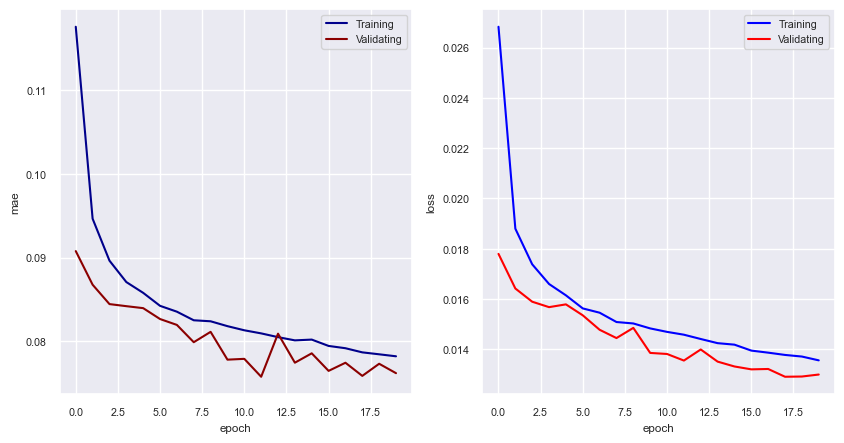

In [81]:
def plot_metrics(train):
    plt.figure(figsize=(10, 5))

    ax1 = plt.subplot(1, 2, 1)
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('mae')
    ax1.plot(train.history['mae'], color='darkblue', label='Training')
    ax1.plot(train.history['val_mae'], color='darkred', label='Validating')
    ax1.legend()

    ax1 = plt.subplot(1, 2, 2)
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.plot(train.history['loss'], color='blue', label='Training')
    ax1.plot(train.history['val_loss'], color='red', label='Validating')
    ax1.legend()


plot_metrics(historial_train)


Model evaluation.

In [82]:
mae_train = mean_absolute_error(y_train, keras_estimator.predict(X=X_train))
mae_test = mean_absolute_error(y_test, keras_estimator.predict(X=X_test))

mae_train, mae_test = round(mae_train, 4), round(mae_test, 4)

print(f'\nMAE Train: {mae_train}')
print(f'MAE Test: {mae_test}')



MAE Train: 3111.2369
MAE Test: 3199.1166


In [83]:
keras_estimator


MyTransformedTargetRegressor(regressor=Pipeline(steps=[('transformer',
                                                        VehiclesDataTransformer()),
                                                       ('outlier',
                                                        VehiclesOutlierTransformer()),
                                                       ('imputer',
                                                        VehiclesImputeTransformer()),
                                                       ('preprocessor',
                                                        ColumnTransformer(transformers=[('min_max',
                                                                                         MinMaxScaler(),
                                                                                         ['model_year',
                                                                                          'cylinders',
                                                                                          'odometer',
                                                                                          'days_listed']),
                                                                                        ('one_hot',
                                                                                         OneHotEncoder(drop='first',
                                                                                                       sparse_output=False),
                                                                                         ['model',
                                                                                          'type',
                                                                                          'paint_color',
                                                                                          'is_4wd']),
                                                                                        ('condition',
                                                                                         OrdinalEncoder(categories=[['new',
                                                                                                                     'like '
                                                                                                                     'new',
                                                                                                                     'excellent',
                                                                                                                     'good',
                                                                                                                     'fair',
                                                                                                                     'salvage']]),
                                                                                         ['condition'])])),
                                                       ('model',
                                                        <keras.engine.sequential.Sequential object at 0x000001D43485DFD0>)]),
                             target_transformer=MinMaxScaler())

In [92]:
results.loc['Keras (MLP)'] = {'TYPE': 'DL', 'POLY_DEGREE': None, 'SCORE': -mae_test,
                              'ESTIMATOR': keras_estimator}
results


,TYPE,POLY_DEGREE,SCORE,ESTIMATOR
LinearRegression,ML,1.0,-3962.1433,TransformedTargetRegressor(regressor=Pipeline(...
Lasso,ML,1.0,-6756.3223,TransformedTargetRegressor(regressor=Pipeline(...
Ridge,ML,1.0,-3961.9898,TransformedTargetRegressor(regressor=Pipeline(...
ElasticNet,ML,1.0,-5744.8384,TransformedTargetRegressor(regressor=Pipeline(...
Keras (MLP),DL,NaN,-3199.1166,MyTransformedTargetRegressor(regressor=Pipelin...


# Resume

In [93]:
results_sort = results.sort_values(by=['SCORE'], ascending=[False])
results_sort


,TYPE,POLY_DEGREE,SCORE,ESTIMATOR
Keras (MLP),DL,NaN,-3199.1166,MyTransformedTargetRegressor(regressor=Pipelin...
Ridge,ML,1.0,-3961.9898,TransformedTargetRegressor(regressor=Pipeline(...
LinearRegression,ML,1.0,-3962.1433,TransformedTargetRegressor(regressor=Pipeline(...
ElasticNet,ML,1.0,-5744.8384,TransformedTargetRegressor(regressor=Pipeline(...
Lasso,ML,1.0,-6756.3223,TransformedTargetRegressor(regressor=Pipeline(...


<AxesSubplot: >

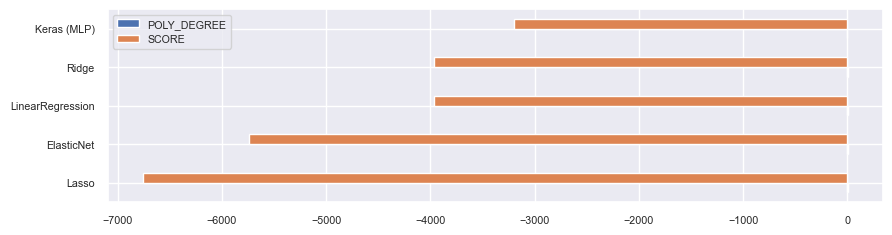

In [94]:
plt.rc('figure', figsize=(10, results_sort.shape[0]*.5))
results_sort[::-1].plot.barh(rot=0)


In [95]:
print(
    f'Best tentative algorithm "{results_sort.iloc[0].name}" with SCORE={-results_sort.iloc[0].SCORE}.')


Best tentative algorithm "Keras (MLP)" with SCORE=3199.1166.


In [96]:
best_sklearn_model = results_sort[results_sort.TYPE == 'ML'].iloc[0].ESTIMATOR
best_keras_model = results_sort[results_sort.TYPE == 'DL'].iloc[0].ESTIMATOR


## Export

Save to file.

In [89]:
sklearn_model_filename = 'resources/sklearn_model.pkl'
keras_model_folder = 'resources/keras_model'

pickle.dump(best_sklearn_model, open(sklearn_model_filename, 'wb'))
best_keras_model.save(keras_model_folder)


Load from file.

In [90]:
sklearn_model_loaded = pickle.load(open(sklearn_model_filename, 'rb'))
keras_model_loaded = MyTransformedTargetRegressor.load(keras_model_folder)

sklearn_model_loaded, keras_model_loaded


(TransformedTargetRegressor(regressor=Pipeline(steps=[('transformer',
                                                       VehiclesDataTransformer()),
                                                      ('outlier',
                                                       VehiclesOutlierTransformer()),
                                                      ('imputer',
                                                       VehiclesImputeTransformer()),
                                                      ('preprocessor',
                                                       ColumnTransformer(transformers=[('standard',
                                                                                        StandardScaler(),
                                                                                        ['model_year',
                                                                                         'cylinders',
                                                              

## Predict

In [91]:
# _X = df.sample(20)
_X = df[:20]

pred_df = pd.DataFrame(data={'REAL': _X[target_column],
                             'SKLEARN_PRED': sklearn_model_loaded.predict(X=_X),
                             'KERAS_PRED': keras_model_loaded.predict(X=_X)})

pred_df


,REAL,SKLEARN_PRED,KERAS_PRED
0,9400,10533.238373,8836.579102
1,25500,17008.839560,15547.087891
2,5500,8273.551122,7663.991699
3,1500,7401.409450,4383.302734
4,14900,11951.243545,11396.803711
5,14990,14079.159467,15599.169922
6,12990,12507.568413,11877.789062
7,15990,14225.910751,14855.477539
8,11500,10450.029194,8844.904297
9,9200,8500.557289,7746.620605
